In [1]:
import pandas as pd

import numpy as np

import pickle

from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

from optimum.bettertransformer import BetterTransformer

import torch

import progressbar

import csv

import sys
np.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)

import matplotlib.pyplot as plt

c:\Users\Lucas Alponti\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Abrindo o objeto dataframe
with open(r'df-novos891-tokenizado.pickle', 'rb') as pickledfile:
    df = pickle.load(pickledfile)

In [3]:
df.tail()

,index,Assunto,Texto original,Texto semi-tratado,Existe,Texto tratado,Tokenizadas,id_categ,n_tokens,n_uniq_tokens
4450,7471,Direito Civil,\nEmenta: Ação civil pública julgada procedent...,Ação civil pública julgada procedente — Apelaç...,0,Ação civil pública julgada procedente — Apelaç...,"[101, 14103, 3154, 3352, 19399, 285, 5160, 923...",886,221,152
4451,7472,Direito Civil,\nEmenta: ACÓRDÃO\nRESPONSABILIDADE CIVIL - Ac...,ACÓRDÃO RESPONSABILIDADE CIVIL - Acidente de v...,0,ACÓRDÃO RESPONSABILIDADE CIVIL - Acidente de v...,"[101, 11247, 22369, 22322, 22319, 16484, 257, ...",887,189,145
4452,7473,Direito Civil,\n\n\t\t\t\t\t\t\t\t\t\t\t\t\tEmenta:\n\t\t\t\...,"""EMBARGOS DE DECLARAÇÃO. ACÓRDÃO. CONTRADIÇÃO....",0,"""EMBARGOS DE DECLARAÇÃO. ACÓRDÃO. CONTRADIÇÃO....","[101, 107, 192, 17166, 6765, 17807, 22308, 108...",888,78,64
4453,7474,Direito Civil,\n\n\t\t\t\t\t\t\t\t\t\t\t\t\tEmenta:\n\t\t\t\...,Embargos de declaração - Fundamentação do» emb...,0,Embargos de declaração - Fundamentação do» emb...,"[101, 2416, 159, 1289, 125, 8030, 118, 16802, ...",889,37,31
4454,7475,Direito Civil,\nEmenta: * RESPONSABILIDADE CIVIL - ACIDENTE ...,* RESPONSABILIDADE CIVIL - ACIDENTE DE TRANSIT...,0,* RESPONSABILIDADE CIVIL - ACIDENTE DE TRANSIT...,"[101, 115, 257, 13209, 12234, 5903, 14390, 223...",890,771,442


In [4]:
# Abrindo o name mapping
with open(r'rfbow-mapping.pickle', 'rb') as pickledfile:
    le_name_mapping = pickle.load(pickledfile)

In [5]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased')

<h2>Modelo Random Forest - Bag of Words</h2>

In [17]:
# Abrindo o bag-of-words
with open(r'bow-novos891.pickle', 'rb') as pickledfile:
    x = pickle.load(pickledfile)

In [18]:
# Abrindo o modelo final
with open(r'random-forest-bow-final.pickle', 'rb') as pickledfile:
    model = pickle.load(pickledfile)

In [19]:
result = model.predict(x)

In [20]:
result_label = np.array([list(le_name_mapping.keys())[list(le_name_mapping.values()).index(i)] for i in result])

In [21]:
cm = confusion_matrix(np.array(df['Assunto']), result_label, labels = list(le_name_mapping.keys()))

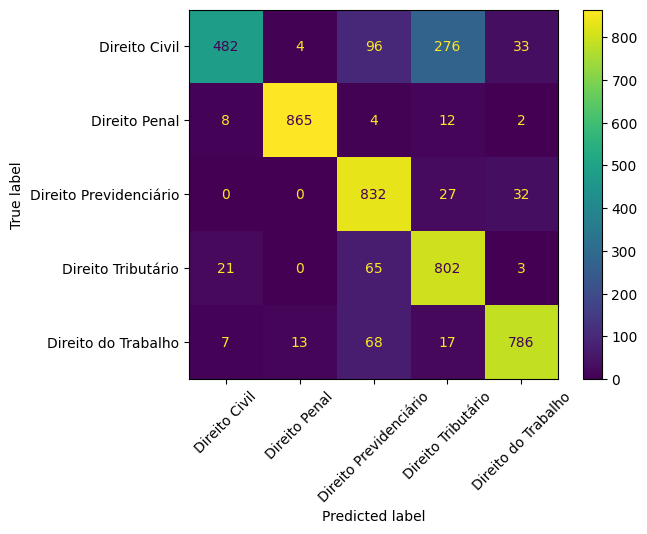

In [22]:
disp = ConfusionMatrixDisplay(cm, display_labels = list(le_name_mapping.keys()))
disp.plot(xticks_rotation=45.0)
plt.show()

In [23]:
cm.diagonal()/cm.sum(axis=1)

array([0.54096521, 0.9708193 , 0.93378227, 0.90011223, 0.88215488])

<h2>Modelo Random Forest - TF-IDF</h2>

In [24]:
# Abrindo o tf-idf
with open(r'tfidf-novos891.pickle', 'rb') as pickledfile:
    x2 = pickle.load(pickledfile)

In [25]:
# Abrindo o modelo final
with open(r'random-forest-tfidf-final.pickle', 'rb') as pickledfile:
    model2 = pickle.load(pickledfile)

In [26]:
result2 = model2.predict(x2)

In [27]:
result2_label = np.array([list(le_name_mapping.keys())[list(le_name_mapping.values()).index(i)] for i in result2])

In [28]:
cm2 = confusion_matrix(np.array(df['Assunto']), result2_label, labels = list(le_name_mapping.keys()))

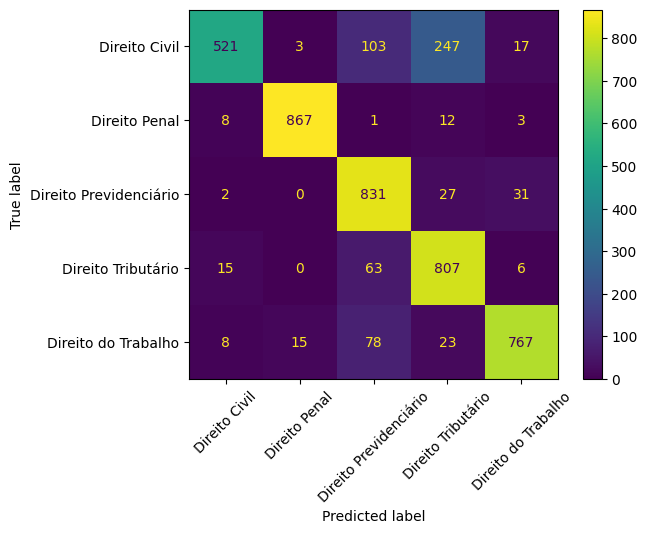

In [29]:
disp2 = ConfusionMatrixDisplay(cm2, display_labels = list(le_name_mapping.keys()))
disp2.plot(xticks_rotation=45.0)
plt.show()

In [30]:
cm2.diagonal()/cm2.sum(axis=1)

array([0.58473625, 0.97306397, 0.93265993, 0.90572391, 0.86083053])

<h2>Modelo Random Forest - BERT</h2>

In [31]:
bertmodel = BetterTransformer.transform(AutoModel.from_pretrained('neuralmind/bert-large-portuguese-cased'))

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


In [33]:
# Obtendo o último hidden state para o token [CLS]

widgets = [' [',
         progressbar.Timer(),
         '] ',
           progressbar.Bar('*'),' (',
           progressbar.ETA(), ') ',
          ]
bar = progressbar.ProgressBar(maxval = len(df), widgets=widgets).start()

# salvando para CSV, assim caso o computador desligue, o progresso não será perdido
with open(r'embeddings_novos891.csv', 'w') as csvfile:
  csvwriter = csv.writer(csvfile, delimiter=';', lineterminator = '\n')
  csvwriter.writerow(['Index', 'Embedding'])

  with torch.no_grad():
    for i in range(len(df)):
      embeddings = bertmodel(tokenizer.encode(df['Texto tratado'][i], return_tensors='pt', max_length=512, truncation=True))['last_hidden_state'][0][0].cpu().detach().numpy()
      # salvando para CSV, assim caso o computador desligue, o progresso não será perdido
      csvwriter.writerow([i, embeddings])
      bar.update(i+1)

In [34]:
embeddings = pd.read_csv(r'embeddings_novos891.csv', sep=';')

In [35]:
embeddings.index = embeddings['Index'].values
embeddings.drop('Index', axis=1, inplace=True)

In [36]:
for i in range(len(embeddings)):
    row = embeddings['Embedding'][i].replace('[', '').replace(']', '').split(' ')
    while '' in row:
        row.remove('')
    row = np.array([float(elem) for elem in row])
    embeddings.loc[i, 'Embedding'] = row

In [37]:
# Abrindo o modelo final
with open(r'random-forest-bert-final.pickle', 'rb') as pickledfile:
    model3 = pickle.load(pickledfile)

In [38]:
result3 = model3.predict(embeddings['Embedding'].to_list())

In [39]:
result3_label = np.array([list(le_name_mapping.keys())[list(le_name_mapping.values()).index(i)] for i in result3])

In [40]:
cm3 = confusion_matrix(np.array(df['Assunto']), result3_label, labels = list(le_name_mapping.keys()))

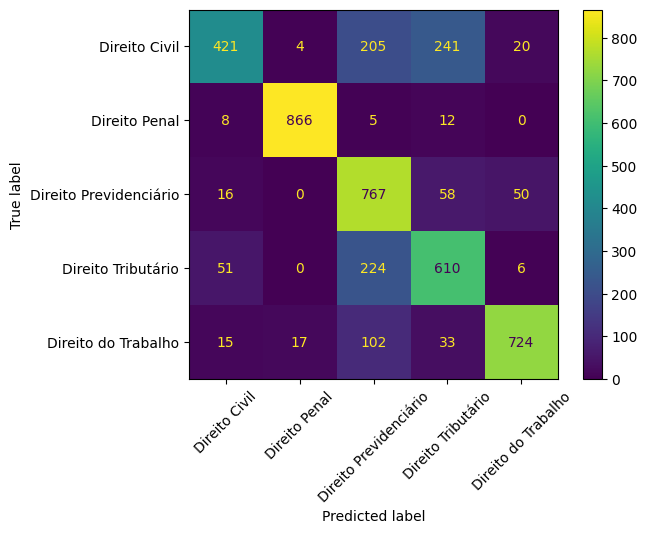

In [41]:
disp3 = ConfusionMatrixDisplay(cm3, display_labels = list(le_name_mapping.keys()))
disp3.plot(xticks_rotation=45.0)
plt.show()

In [42]:
cm3.diagonal()/cm3.sum(axis=1)

array([0.47250281, 0.97194164, 0.86083053, 0.68462402, 0.81257015])

<h2>Modelo BERT</h2>

In [5]:
model4 = AutoModelForSequenceClassification.from_pretrained("lucasbalponti/total")

In [7]:
pipe = TextClassificationPipeline(model=model4, tokenizer=tokenizer)

In [8]:
result4 = [pipe(df['Texto tratado'][i], 
                **{'max_length': 512, 'truncation':'only_first'},
                top_k=None) for i in range(len(df))]

In [9]:
result4n = [max(row, key = lambda i: i['score'])['label'][-1] for row in result4]

In [10]:
result4_label = np.array([list(le_name_mapping.keys())[list(le_name_mapping.values()).index(int(i))] for i in result4n])

In [11]:
cm4 = confusion_matrix(np.array(df['Assunto']), result4_label, labels = list(le_name_mapping.keys()))

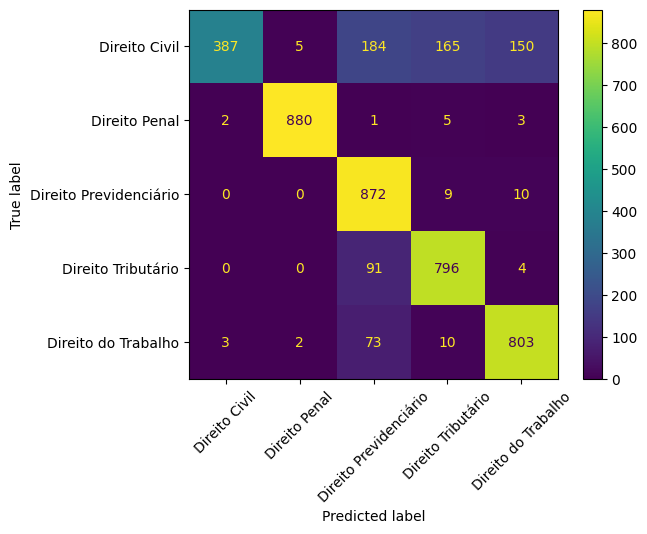

In [12]:
disp4 = ConfusionMatrixDisplay(cm4, display_labels = list(le_name_mapping.keys()))
disp4.plot(xticks_rotation=45.0)
plt.show()

In [13]:
cm4.diagonal()/cm4.sum(axis=1)

array([0.43434343, 0.98765432, 0.97867565, 0.89337823, 0.90123457])

In [43]:
df['result_bow'] = list(result_label)
df['result_tfidf'] = list(result2_label)
df['result-bert-rf'] = list(result3_label)
df['result-bert'] = list(result4_label)
df['logits-bert'] = list(result4)

In [44]:
df.head()

,index,Assunto,Texto original,Texto semi-tratado,Existe,Texto tratado,Tokenizadas,id_categ,n_tokens,n_uniq_tokens,result-bert,logits-bert,result_bow,result_tfidf,result-bert-rf
0,0,Direito Tributário,\n\n\t\t\t\t\t\t\t\t\t\t\t\t\tEmenta:\n\t\t\t\...,EMBARGOS DE DECLARAÇÃO – Alegação de omissão e...,0,EMBARGOS DE DECLARAÇÃO – Alegação de omissão e...,"[101, 192, 17166, 6765, 17807, 22308, 10836, 1...",0,99,82,Direito Previdenciário,"[{'label': 'LABEL_2', 'score': 0.9987806677818...",Direito Previdenciário,Direito Previdenciário,Direito Previdenciário
1,1,Direito Tributário,\nEmenta: APELAÇÃO – Execução Fiscal – Multa...,APELAÇÃO – Execução Fiscal – Multa Administrat...,0,APELAÇÃO – Execução Fiscal – Multa Administrat...,"[101, 12127, 9008, 22301, 22402, 16484, 1379, ...",1,217,149,Direito Tributário,"[{'label': 'LABEL_3', 'score': 0.9997418522834...",Direito Tributário,Direito Tributário,Direito Tributário
2,2,Direito Tributário,\nEmenta: EMBARGOS DE DECLARAÇÃO\r\nAlegação d...,EMBARGOS DE DECLARAÇÃO Alegação de omissão – I...,0,EMBARGOS DE DECLARAÇÃO Alegação de omissão – I...,"[101, 192, 17166, 6765, 17807, 22308, 10836, 1...",2,123,90,Direito Previdenciário,"[{'label': 'LABEL_2', 'score': 0.7974733114242...",Direito Tributário,Direito Tributário,Direito Tributário
3,3,Direito Tributário,\nEmenta: APELAÇÃO CÍVEL – Mandado de Seguran...,APELAÇÃO CÍVEL – Mandado de Segurança – ITBI –...,0,APELAÇÃO CÍVEL – Mandado de Segurança – ITBI –...,"[101, 12127, 9008, 22301, 22402, 16484, 187, 2...",3,167,129,Direito Tributário,"[{'label': 'LABEL_3', 'score': 0.9880988001823...",Direito Tributário,Direito Tributário,Direito Previdenciário
4,4,Direito Tributário,\nEmenta: AGRAVO DE INSTRUMENTO – Execução fi...,AGRAVO DE INSTRUMENTO – Execução fiscal – Exce...,0,AGRAVO DE INSTRUMENTO – Execução fiscal – Exce...,"[101, 177, 22328, 5650, 22339, 22317, 10836, 1...",4,143,114,Direito Tributário,"[{'label': 'LABEL_3', 'score': 0.9996102452278...",Direito Tributário,Direito Tributário,Direito Tributário


In [45]:
# Salvando o objeto dataframe
with open(r'df-novos891-result.pickle', 'wb') as pickledfile:
    pickle.dump(df, pickledfile, protocol=pickle.HIGHEST_PROTOCOL)

<h2>Modelo BERT - 1 epoch & Weighted loss</h2>

In [5]:
model5 = AutoModelForSequenceClassification.from_pretrained("lucasbalponti/modelo-pesos")

c:\Users\Lucas Alponti\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lucas Alponti\.cache\huggingface\hub\models--lucasbalponti--modelo-pesos. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [7]:
pipe5 = TextClassificationPipeline(model=model5, tokenizer=tokenizer)

In [8]:
result5 = [pipe5(df['Texto tratado'][i], 
                **{'max_length': 512, 'truncation':'only_first'},
                top_k=None) for i in range(len(df))]

In [9]:
result5n = [max(row, key = lambda i: i['score'])['label'][-1] for row in result5]

In [10]:
result5_label = np.array([list(le_name_mapping.keys())[list(le_name_mapping.values()).index(int(i))] for i in result5n])

In [11]:
cm5 = confusion_matrix(np.array(df['Assunto']), result5_label, labels = list(le_name_mapping.keys()))

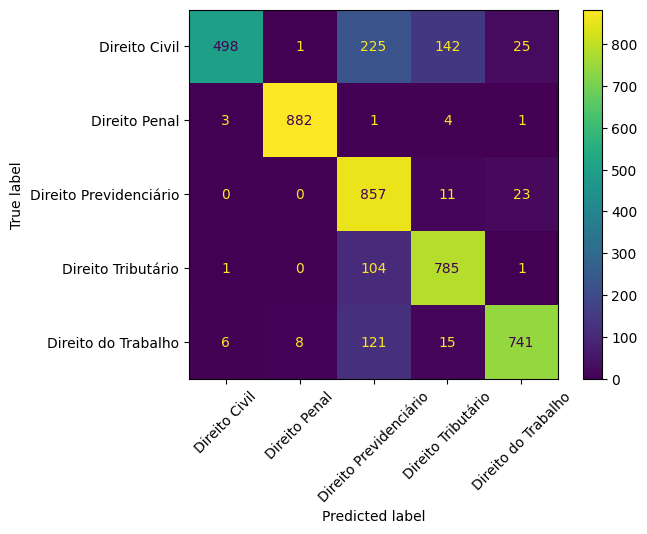

In [12]:
disp5 = ConfusionMatrixDisplay(cm5, display_labels = list(le_name_mapping.keys()))
disp5.plot(xticks_rotation=45.0)
plt.show()

In [13]:
cm5.diagonal()/cm5.sum(axis=1)

array([0.55892256, 0.98989899, 0.96184063, 0.88103255, 0.83164983])

In [14]:
# Abrindo o objeto dataframe
with open(r'df-novos891-result.pickle', 'rb') as pickledfile:
    df_result = pickle.load(pickledfile)

In [15]:
df_result['result-bert-wl'] = list(result5_label)
df_result['logits-bert-wl'] = list(result5)

In [16]:
# Salvando o objeto dataframe
with open(r'df-novos891-result.pickle', 'wb') as pickledfile:
    pickle.dump(df_result, pickledfile, protocol=pickle.HIGHEST_PROTOCOL)

<h2>Modelo BERT - 2 epoch & Weighted loss</h2>

In [6]:
model6 = AutoModelForSequenceClassification.from_pretrained("lucasbalponti/modelo-pesos-2")

c:\Users\Lucas Alponti\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lucas Alponti\.cache\huggingface\hub\models--lucasbalponti--modelo-pesos-2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [7]:
pipe6 = TextClassificationPipeline(model=model6, tokenizer=tokenizer)

In [8]:
result6 = [pipe6(df['Texto tratado'][i], 
                **{'max_length': 512, 'truncation':'only_first'},
                top_k=None) for i in range(len(df))]

In [9]:
result6n = [max(row, key = lambda i: i['score'])['label'][-1] for row in result6]

In [10]:
result6_label = np.array([list(le_name_mapping.keys())[list(le_name_mapping.values()).index(int(i))] for i in result6n])

In [11]:
cm6 = confusion_matrix(np.array(df['Assunto']), result6_label, labels = list(le_name_mapping.keys()))

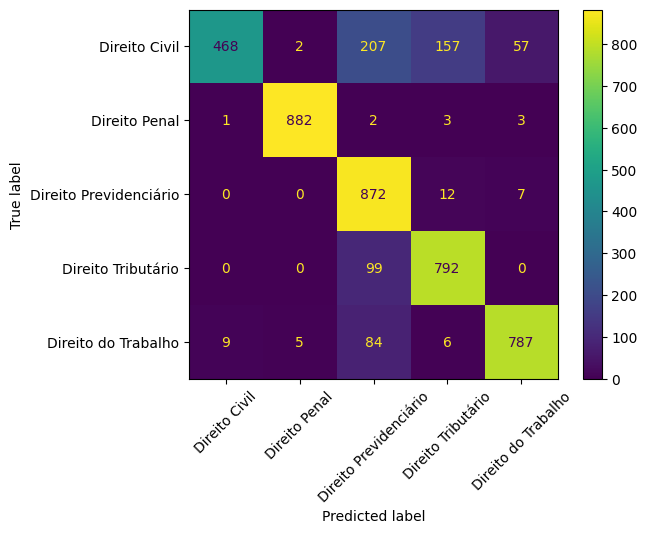

In [12]:
disp6 = ConfusionMatrixDisplay(cm6, display_labels = list(le_name_mapping.keys()))
disp6.plot(xticks_rotation=45.0)
plt.show()

In [13]:
cm6.diagonal()/cm6.sum(axis=1)

array([0.52525253, 0.98989899, 0.97867565, 0.88888889, 0.88327722])

In [14]:
# Abrindo o objeto dataframe
with open(r'df-novos891-result.pickle', 'rb') as pickledfile:
    df_result = pickle.load(pickledfile)

In [15]:
df_result['result-bert-wl-2'] = list(result6_label)
df_result['logits-bert-wl-2'] = list(result6)

In [16]:
# Salvando o objeto dataframe
with open(r'df-novos891-result.pickle', 'wb') as pickledfile:
    pickle.dump(df_result, pickledfile, protocol=pickle.HIGHEST_PROTOCOL)